In [1]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,AutoModelForMaskedLM , Trainer,TrainingArguments,BitsAndBytesConfig,pipeline,default_data_collator
from peft import get_peft_model,LoraConfig
import datasets
import torchmetrics
import torch
from hqq.engine.hf import HQQModelForCausalLM
from hqq.models.hf.base import AutoHQQHFModel
from huggingface_hub import snapshot_download
#import deepspeed
import os
import pandas as pd
import json
from var_dump import var_dump
from bs4 import BeautifulSoup

cache_dir='/proj/ciptmp/ix05ogym/.cache/'
output_dir = cache_dir+'outputs/'


/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No ROCm runtime is found, using ROCM_HOME='/usr'


In [ ]:
KEYWORDS={
        #----------------------form--------------------------------------
       'firstname':['firstname','first_name','forename','first','first-name'],
       'lastname':['lastname','last_name','surename','last','last-name'] ,
       'email':['email','e-mail','username','user_name','user-name','type="email"'], 
       'password':['password'], 
       'cv':['cv','resume','curriculum','vitae'],
       'birthdate':['birthdate','birth','dateofbirth','date-of-birth','birth-date'],
       'phonenumber':['phonenumber','phone','telephone','tel'],
       'housenumber':['hausnummer'],
       'residentcountry':['resident','country'],
       'citizencountry':['citizen','citizenship','city'],
       'transcript':['transcript'],
       'coverletter':['coverletter','cover', 'letter'], 
       'picture':['picture'], 
       'address':['address','location'],
       'linkedin':['linkedin'],
       'github':['github'],
       'xing':['xing'],
       'twitter':['twitter'],
       'website':['website'],
       'postalcode':['postalcode','zip','zip-code','postal'],
       'city':['city'],
       'housenumber':['housenumber'], 
       'salary':['salary'],
       'sex':['sex','gender'], 
       'availablefrom':['noticeprieod'],
       'file':['type="file"'],
       'captcha':['captcha'],
       'submit':['apply','type="submit"'],
       'cancel':['cancel'],
       'fake':['fake'],
       'question':['question'],
       'agree':['agree'],
       'other':['other'],
       'apply':['apply'],
       'recommendation':['recommendation'],
       'workherebefore':['workherebefore'],
       'findus':['find'],
       'dropbox':['dropbox'],
       'googledrive':['google drive'],
       'workhours':['workhours'],
       'workduration':[''],
       'visa':['visa'],
       'eligible':['eligible'],
       'germanlevel':['germanlevel'],
       'company':[''],#current company
       'relocate':[''],
       'universityenrollment':[],#are a student?
       'englishlevel':[],
       #important about job
       #important about jobplace?
              
       #-------------------------------------------------------------------
       #-----------------------------------btns ---------------------------
       'login':['login','sign'],
       'username':['username'],
       'register':['register','sign'],
       'cookie':['cookie'],
       'next':['apply now','next'],
       'search':[],
       #-------------------------------------------------------------------
       
       
       
       
       }


LABEL_INDEX_TO_KEY = list(KEYWORDS.keys()) #self.personal_data.columns
i =0
LABEL_KEY_TO_INDEX = {}
for key in KEYWORDS:
            LABEL_KEY_TO_INDEX[key] =i
            i+=1 

In [ ]:
for x in LABEL_INDEX_TO_KEY:
    print(f'"{x}"',end=' , ')
          

"firstname" , "lastname" , "email" , "password" , "cv" , "birthdate" , "phonenumber" , "housenumber" , "residentcountry" , "citizencountry" , "transcript" , "coverletter" , "picture" , "address" , "linkedin" , "github" , "xing" , "twitter" , "website" , "postalcode" , "city" , "salary" , "sex" , "availablefrom" , "file" , "captcha" , "submit" , "cancel" , "fake" , "question" , "agree" , "other" , "apply" , "recommendation" , "workherebefore" , "findus" , "dropbox" , "googledrive" , "workhours" , "workduration" , "visa" , "eligible" , "germanlevel" , "company" , "relocate" , "universityenrollment" , "englishlevel" , "login" , "username" , "register" , "cookie" , "next" , "search" , 

In [ ]:
mydata = pd.read_pickle('input_text.pkl')
#mydata.reset_index(inplace=True)
mydata['element'][1]

'<input data-testid="textinput" id="email" required="" type="email" autocomplete="email" name="email" class="sc-bsgiji jskkmm" value="">'

<Axes: xlabel='labels'>

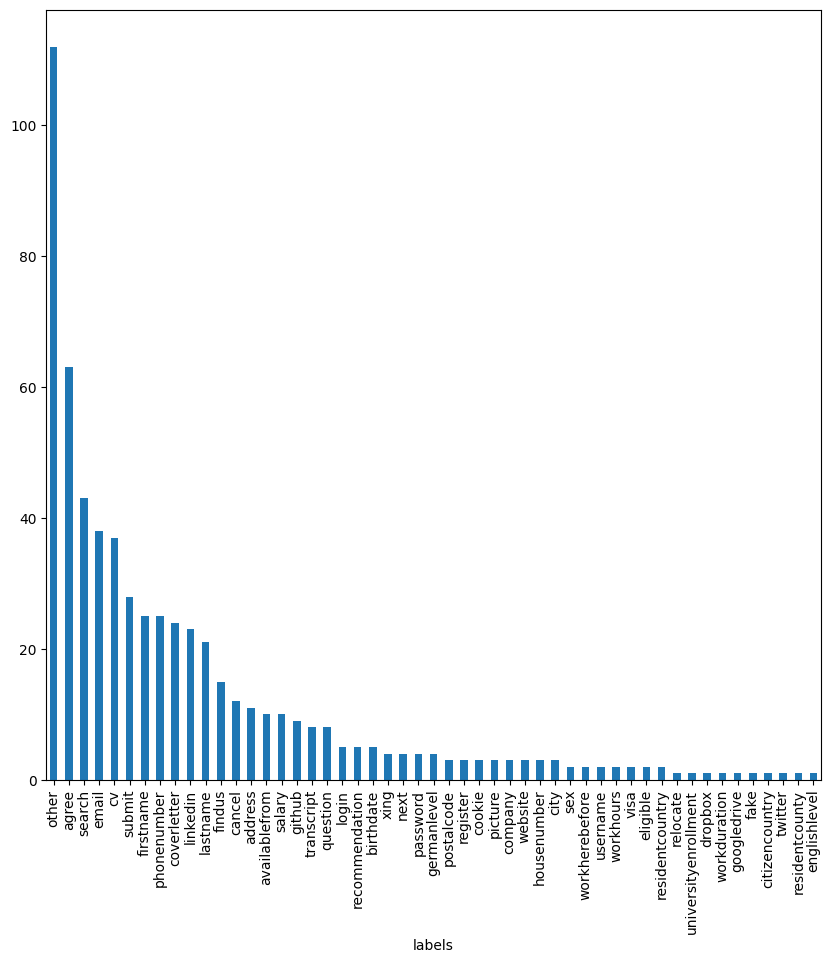

In [ ]:
mydata['labels'].value_counts().plot(figsize=(10,10), kind='bar')

In [ ]:
mydata[mydata['labels']=='residentcounty']#='residentcountry'
mydata.loc[45,'labels'] = 'residentcountry'

In [ ]:
"""index = (inp['input_ids']== toknizer.mask_token_id).int().argmax().item()
print(index ,o.logits.shape)
token_id = o.logits[0,index,:].argsort(descending=True)
r = toknizer.convert_ids_to_tokens(token_id[:5])
MASK = toknizer.convert_tokens_to_string(r[0:1])
"""

"index = (inp['input_ids']== toknizer.mask_token_id).int().argmax().item()\nprint(index ,o.logits.shape)\ntoken_id = o.logits[0,index,:].argsort(descending=True)\nr = toknizer.convert_ids_to_tokens(token_id[:5])\nMASK = toknizer.convert_tokens_to_string(r[0:1])\n"

In [2]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base" , cache_dir=cache_dir)
model  = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base",
                          #quantization_config=GPTQConfig(bits=4, disable_exllama=False),
                          #load_in_8bit=True,
                          num_labels=len(LABEL_INDEX_TO_KEY),
                          cache_dir=cache_dir)

#target_modules =['out_proj']
model = get_peft_model(model,LoraConfig(task_type= 'SEQ_CLS'))
model.print_trainable_parameters()
"""
for n, p in model.named_parameters():
    if 'classifier' not in n:
        p.requires_grad = False
"""
# Check which parameters are still trainable
for n, p in model.named_parameters():
    if p.requires_grad:
        print(f'{n} {p.shape}')
        

model

OSError: [Errno 122] Disk quota exceeded: '/proj/ciptmp/ix05ogym/.cache/models--FacebookAI--roberta-base'

In [ ]:
data = datasets.Dataset.from_pandas(mydata)
data = data.train_test_split(0.2)
train_dataset = data['train']
test_dataset = data['test']

#print(len(test_dataset),len(test_dataset['labels']))
def preprocess(example):
    
    x = tokenizer(example['input_text'],return_tensors='pt' , padding=False,truncation=True ,max_length=512)
    x['input_ids'] = x['input_ids'][0]
    x['attention_mask'] = x['attention_mask'][0]
    x['label'] = LABEL_KEY_TO_INDEX[ example['labels'] ]
    return x



train_dataset_tokenized =  train_dataset.map(preprocess,remove_columns=['text', 'element', 'labels', 'input_text'])
test_dataset_tokenized =  test_dataset.map(preprocess,remove_columns=['text', 'element', 'labels', 'input_text'])

train_dataset_tokenized

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map: 100%|██████████| 121/121 [00:00<00:00, 5334.36 examples/s]


Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 480
})

In [ ]:
test_dataset_tokenized['input_ids']
#tokenizer.cls_token_id

[[0,
  10936,
  36037,
  7,
  84,
  3476,
  41552,
  102,
  48225,
  40635,
  13082,
  640,
  1401,
  4,
  879,
  5090,
  4,
  1957,
  73,
  605,
  42557,
  113,
  1002,
  40635,
  1215,
  35763,
  113,
  1270,
  40635,
  10936,
  36037,
  7,
  5,
  542,
  5090,
  1315,
  3476,
  46479,
  50118,
  10936,
  36037,
  7,
  947,
  282,
  39596,
  131,
  2126,
  3476,
  50118,
  49138,
  102,
  15698,
  2],
 [0,
  10555,
  1009,
  41552,
  46797,
  1907,
  40635,
  10555,
  113,
  766,
  40635,
  10555,
  113,
  45729,
  40635,
  16625,
  6380,
  1039,
  46400,
  4,
  175,
  113,
  1380,
  40635,
  3899,
  12,
  17665,
  113,
  1552,
  40635,
  46479,
  2],
 [0,
  3340,
  5895,
  927,
  73,
  2544,
  46398,
  37111,
  5163,
  119,
  22900,
  4926,
  7443,
  9502,
  13650,
  41552,
  46797,
  1907,
  40635,
  29015,
  113,
  13561,
  40635,
  40545,
  3899,
  12,
  9502,
  13650,
  113,
  1380,
  40635,
  3899,
  12,
  17665,
  113,
  766,
  40635,
  40545,
  3899,
  10975,
  9502,
  13650,


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,max_length=512)
s = data_collator(test_dataset_tokenized[0:8])
s

/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'input_ids': tensor([[    0, 10936, 36037,     7,    84,  3476, 41552,   102, 48225, 40635,
         13082,   640,  1401,     4,   879,  5090,     4,  1957,    73,   605,
         42557,   113,  1002, 40635,  1215, 35763,   113,  1270, 40635, 10936,
         36037,     7,     5,   542,  5090,  1315,  3476, 46479, 50118, 10936,
         36037,     7,   947,   282, 39596,   131,  2126,  3476, 50118, 49138,
           102, 15698,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [    0, 10555,  1009, 41552, 46797,  1907, 40635, 10555,   113, 

In [ ]:
print(train_dataset['label'][0])
tokenizer.convert_tokens_to_string( tokenizer.convert_ids_to_tokens( train_dataset_tokenized[32]['input_ids'] ) )
#train_dataset_tokenized[2]['labels']

firstname


'<s><input name="date" type="text" value="" data-toggle="datepicker" autocomplete="off" class="form-control validate_apply_element hasdatepicker" id="dp1715511429038"></s>'

In [ ]:
train_dataset_tokenized[0]

{'label': 31,
 'input_ids': [0,
  506,
  13598,
  1589,
  942,
  38450,
  1735,
  223,
  2879,
  1589,
  942,
  41552,
  46797,
  1907,
  40635,
  15954,
  8304,
  113,
  1380,
  40635,
  26296,
  29,
  12,
  3899,
  12,
  15954,
  30529,
  46797,
  113,
  766,
  40635,
  1215,
  642,
  1343,
  1215,
  466,
  113,
  13561,
  40635,
  1215,
  642,
  1343,
  1215,
  466,
  12,
  22814,
  113,
  923,
  40635,
  22814,
  46479,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [ ]:
#train_dataset_tokenized['labels'][1]

In [ ]:
import torchmetrics
import numpy as np
from var_dump import var_dump
from transformers import DefaultDataCollator

def compute_metric(inp):
    preds , label_ids  = inp
    print(preds.shape)
    
    preds = torch.tensor(preds)
    label_ids = torch.tensor(label_ids)
    
    p_label = preds.argmax(1)
    
    for p,l in zip(p_label,label_ids):
        #print(p,l)
        break
    metric = torchmetrics.Accuracy('multiclass',num_classes=len(LABEL_INDEX_TO_KEY))
    acc = metric(p_label , label_ids )
    print(acc)
    return {'acc':acc}


batch_size = 8
trainer =  Trainer(
    model=model,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,
    compute_metrics=compute_metric,
    #data_collator=data_collator, #DataCollatorWithPadding(tokenizer),
    tokenizer= tokenizer,
    
    args= TrainingArguments(
        output_dir=output_dir,
        save_strategy="no",
        
        overwrite_output_dir=True,
        num_train_epochs=60,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        bf16=True,
        learning_rate=6e-4,
        optim='adamw_torch',
        #max_grad_norm=1.0,  
        do_eval=True,
        eval_strategy="epoch",
        do_train=True,
        logging_steps =100,
        
        
        
        
        
    )
    
)




print(trainer.evaluate(train_dataset_tokenized))
print(trainer.evaluate())

trainer.train()

[2024-06-16 10:00:28,875] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


(480, 53)
tensor(0.0667)
{'eval_loss': 3.977246046066284, 'eval_acc': 0.06666667014360428, 'eval_runtime': 2.2846, 'eval_samples_per_second': 210.102, 'eval_steps_per_second': 26.263}
(121, 53)
tensor(0.0496)
{'eval_loss': 3.9724948406219482, 'eval_acc': 0.04958677664399147, 'eval_runtime': 0.2231, 'eval_samples_per_second': 542.459, 'eval_steps_per_second': 71.73}


Epoch,Training Loss,Validation Loss,Acc
1,No log,3.205901,0.173554
2,2.956200,1.854680,0.586777
3,2.956200,1.604913,0.595041
4,1.223600,1.509637,0.652893
5,0.603900,1.498928,0.669421
6,0.603900,1.449471,0.694215
7,0.353300,1.532146,0.652893
8,0.353300,1.645600,0.661157
9,0.190900,1.720202,0.652893
10,0.116900,1.848957,0.677686


(121, 53)
tensor(0.1736)
(121, 53)
tensor(0.5868)
(121, 53)
tensor(0.5950)
(121, 53)
tensor(0.6529)
(121, 53)
tensor(0.6694)
(121, 53)
tensor(0.6942)
(121, 53)
tensor(0.6529)
(121, 53)
tensor(0.6612)
(121, 53)
tensor(0.6529)
(121, 53)
tensor(0.6777)
(121, 53)
tensor(0.6446)
(121, 53)
tensor(0.6446)
(121, 53)
tensor(0.6694)
(121, 53)
tensor(0.6777)
(121, 53)
tensor(0.7025)
(121, 53)
tensor(0.6860)
(121, 53)
tensor(0.6942)
(121, 53)
tensor(0.7190)
(121, 53)
tensor(0.7190)
(121, 53)
tensor(0.7025)
(121, 53)
tensor(0.7025)
(121, 53)
tensor(0.6942)
(121, 53)
tensor(0.6860)
(121, 53)
tensor(0.6777)
(121, 53)
tensor(0.7190)
(121, 53)
tensor(0.7025)
(121, 53)
tensor(0.6860)
(121, 53)
tensor(0.6612)


KeyboardInterrupt: 

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc
1,No log,2.546322,0.652893
2,No log,2.511027,0.644628
3,No log,0.001930,1.000000


(121, 53)
tensor(0.6529)
(121, 53)
tensor(0.6446)
(121, 53)
tensor(0.6364)


KeyboardInterrupt: 

In [ ]:
trainer.evaluate(train_dataset_tokenized)

(480, 53)
tensor(1.)


{'eval_loss': 0.0019303078297525644, 'eval_acc': 1.0}

In [ ]:
model.classifier.out_proj.weight

In [ ]:
n = 0
ds = train_dataset
for i in range(len(ds)):
    y = preprocess(ds[i:i+1])
    x = tokenizer(y['p'],y['h'],return_tensors='pt' , padding=True,truncation=True ,max_length=512).to('cuda')
    #print(y.keys())
    with torch.no_grad():
        o = model(**x)
        index = o.logits[:,2].argmax(0)
        if LABEL_INDEX_TO_KEY[index]==y['labels'][0]:
            n+=1
            
        

    #break
    
n/len(ds)

In [ ]:

for batch in trainer.get_train_dataloader():
    break
trainer.model.to('cuda')
batch = {k: v.to('cuda') for k, v in batch.items()}
trainer.create_optimizer()
#print(batch)
for _ in range(20):
    outputs = trainer.model(**batch)
    print(trainer.label_names)
    loss = outputs.loss
    print(outputs.logits.shape)
    print(loss)
    loss.backward()
    print(model.classifier.out_proj.weight.grad)
    print(model.classifier.out_proj.bias.grad)
    
    
    trainer.optimizer.step()
    print('-------------------------------------------------')
    print(model.classifier.out_proj.weight)
    
    trainer.optimizer.zero_grad()
    break


In [ ]:
"""bid = json.loads(d['actions'][1]['pos_candidates'][0]['attributes'])['backend_node_id']
print(d['actions'][1]['pos_candidates'])
soup = BeautifulSoup(lll['html'][1])#d['actions'][1]['raw_html'])
#soup = BeautifulSoup(d['actions'][3]['raw_html'])
#s = soup.find( '*' )
# Find all 'div' tags
soup = soup.find('form')
all_tags = soup.find_all()

# Remove all tags except for 'link', 'input', and 'select' tags
i=0
for element in all_tags:
    if element.name  in ['div','text']: 
    #if element.name not in ['a','link', 'input', 'select','radio','button']:
        
        element.unwrap()
    else:
        element['backend_node_id']=i
        
        if 'class' in element.attrs:
            del element['class']
            pass
        if 'bounding_box_rect' in element.attrs:
            del element['bounding_box_rect']
            pass
        if 'is_clickable' in element.attrs:
            del element['is_clickable']
            pass
        
            
        i+=1

     

s = soup.prettify()
#b = s.split("/>")
x = toknizer(s,return_tensors='pt')
print(x['input_ids'].shape[1],x['input_ids'].shape[1]/16348)


print(s)
if False:
    for i in b:
        print(i)
        print('---------------------')
"""

In [ ]:
from IPython.display import display, HTML
display(HTML(s))


In [ ]:
display(HTML(s))


In [ ]:
mydata.iloc[1,:]